In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html(
    '<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area, .output_stderr").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

CSS = """.input_area .output_stderr {height: 2.0em; overflow: hidden}"""  

In [2]:
#### Importing libraries and files ####

#Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt

# Cleaned Ward Level Data Set:
WardData = pd.read_csv('C:/Users/bsalv/OneDrive/Documents/Job Application Materials/GitHub Project Documents/OAF Expansion and FO Hiring/Inward Growth/Analysis/Data/Cleaned Data/IG Ward Level Dataset.csv')


# Converting DistrictName variable into categorical variable for regression. 
DensityData = WardData[['LR2018NetClientGain','LR2018ClientDensity','IGSitesDummy', 'DensityRange', 'TotalLR2017SitesinWard', 'DistrictName', 'Province']]

# Calculating the total change in sites for ward (includes reallocations)
#DensityData['DeltaSites'] = DensityData['TotalSites'] - DensityData['TotalLR2017SitesinWard'] 
#DensityData['DeltaSites1'] = DensityData['LR2018TotalSites'] - DensityData['TotalLR2017SitesinWard'] 

# Calculating the sites that were reallocated (not actually nw) NOT including new sites (IG and OG) for second regression that assumes that real new sites perform differently.


# Creating dummy variables for district allocation of the ward.
DensityData = pd.concat((DensityData, pd.get_dummies(DensityData['DistrictName'], drop_first=True)), axis=1)
del DensityData['DistrictName']


# Selecting the variables for regression:
# Setting variables as target and predictors: Can do this to increase readability
IndpVar = DensityData.iloc[:,2:]
IndpVar = sm.add_constant(IndpVar)
DepVar = DensityData[["LR2018NetClientGain"]]

## One Acre Fund Growth Strategy Analysis

### Introduction

One Acre Fund's expansion strategy is built on the concept of market share. The hypothesis states that as existing market share in a particular area of operations increases, the number of new clients that can be enrolled for the following season diminishes. Therefore we should target areas with low market share over areas of high market share to maximize the number of new clients gained. The purpose of this analysis is to confirm this hypothesis using the results from the most recent cycle of expansion.


### Summary of Results

This regression analysis finds a statistically significant but modest negative relationship between market share and the number of new clients enrolled in the program. The bar graph below represents the relative importance of market share to the overall performance of expansion areas. The key takeaway from this analysis is that while market share is an important consideration in selecting viable expansion areas, it appears to be one of many important factors. However, our current strategy ignores these other factors and focuses solely on market share to identify high potential expansion areas. Based on this analysis, it may be possible to significantly improve the performance of our expansion strategy by using a broader set of variables that includes market share.

Please note that we do see a significant jump in the importance of market share once the market share exceeds 20%.  Still, there is plenty of room to refine our strategy. Also, it appears that market share is very important in areas with a 40+% market share. However, these areas make up a small percentage of total available expansion areas and have a disproportionate number of potential data quality issues. Therefore, we do not believe we should be using data from this group to make conclusions about the expansion strategy as a whole.

C:\Users\bsalv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


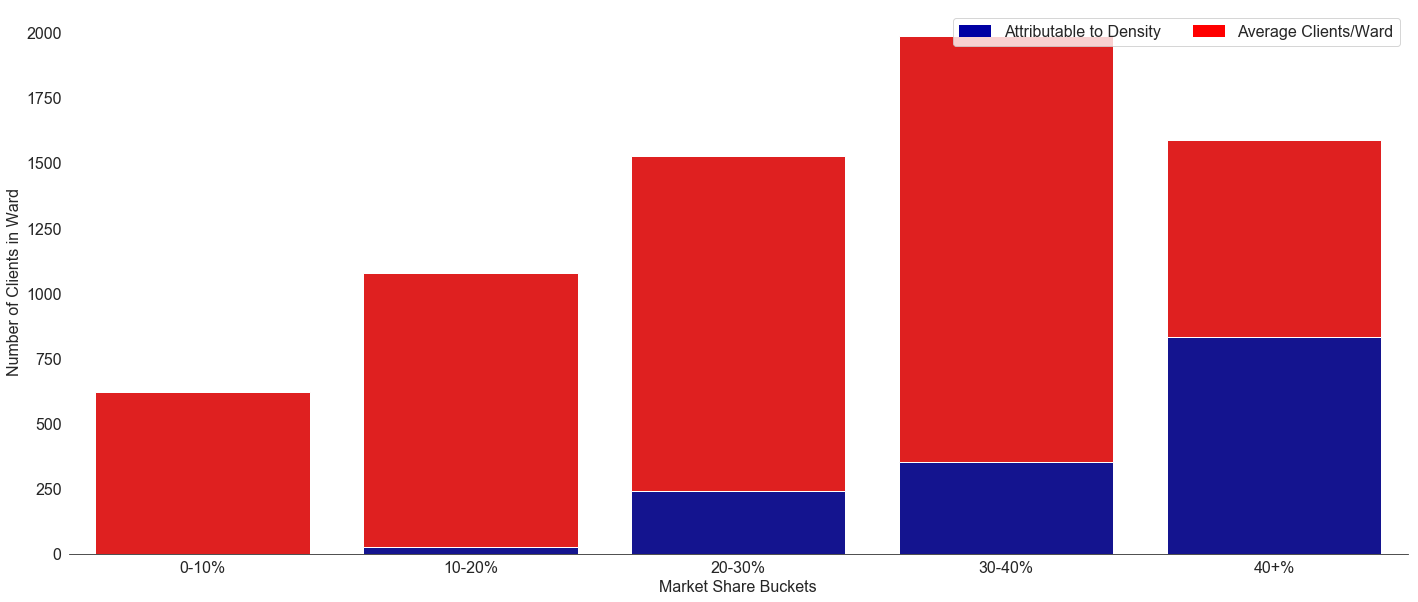

In [3]:
# Table of Net Client Gain as a percentage of total clients: 
# Using Model 3 for interpretability results are about the same as other regressions.

DensityData3 = WardData[['LR2018NetClientGain','LR2017ClientDensity','IGSitesDummy', 'TotalLR2017SitesinWard', 'LR2018RealClients', 'Province']]

# Turning density range into dummy variable to avoid extrapolation.
DensityData3['LR2017ClientDensity'] = pd.cut(DensityData3['LR2017ClientDensity'],5)
DensitybeforeDummies = DensityData3
# Creating table for summary before aggregation
AggDensityTable = DensityData3
DensityData3 = pd.concat((DensityData3, pd.get_dummies(DensityData3['LR2017ClientDensity'], drop_first=True)), axis=1)
del DensityData3['LR2017ClientDensity']

# Creating dummy variables for district allocation of the ward.
DensityData3 = pd.concat((DensityData3, pd.get_dummies(DensityData3['Province'], drop_first=True)), axis=1)
del DensityData3['Province']


# Setting Dependent and Independent variables:
IndpVar = DensityData3.iloc[:,1:]
del IndpVar['LR2018RealClients']
IndpVar = sm.add_constant(IndpVar)
DepVar = DensityData3[["LR2018NetClientGain"]]

## Regression Specification 1: Continous Variable on Density and Number of Growth Sites Added
model3 = sm.OLS(DepVar, IndpVar).fit()
coeff = pd.DataFrame(model3.params)

# Extracting the coefficients for client density ranges:
# First dropping other coefficients:
densitycoeff = coeff.drop(coeff.index[1:3])
densitycoeff = densitycoeff.reset_index()
#print(densitycoeff)

# Creating table to small size of the density effect.
# Aggregating AggDensityTable table by value of cut 2017 density.
ClientsPerWard = AggDensityTable[['LR2017ClientDensity','LR2018RealClients']]
AvergeClientsPerWard = ClientsPerWard.groupby(['LR2017ClientDensity']).mean().reset_index()

# Concatenating the density coefficients.
AvergeClientsPerWard = pd.concat((AvergeClientsPerWard, densitycoeff), axis =1, ignore_index = True)
#AvergeClientsPerWard = AvergeClientsPerWard.drop(AvergeClientsPerWard.index[-1])


# Subtract from the constant to see the progression becuase the constant is the lowest category
list(AvergeClientsPerWard.columns)
AvergeClientsPerWard[3] = AvergeClientsPerWard[3] - AvergeClientsPerWard[3][0]  
AvergeClientsPerWard['% of Average Clients/Ward'] = abs(AvergeClientsPerWard[3])/AvergeClientsPerWard[1]*100   

# Removing the highest density bracket since it has a low sample size.


# Creating Stacked BarPlot to show Percentage - the story is the comparison density, IG site and Province (as a proxy for value prop).
#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = AvergeClientsPerWard[0], y = AvergeClientsPerWard[1], color = "red")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = AvergeClientsPerWard[0], y = abs(AvergeClientsPerWard[3]), color = "#0000A3")

topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')

l = plt.legend([bottombar, topbar], ['Attributable to Density', 'Average Clients/Ward'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(True)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_xlabel("Market Share Buckets")
bottom_plot.set_ylabel("Number of Clients in Ward")
bottom_plot.set_xticklabels(['0-10%', '10-20%', '20-30%', '30-40%', '40+%'])

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)

### Next Steps:
We suggest that we take two steps to improve our process of identifying expansion areas:  

1. Investigating data quality issues and investing in build better datasets.
2. Investigating other factors that may be more important to the performance of an expansion area.

Please see the document titled "Inward Growth Site Selection Proposal" to see our proposal for developing a new method of identifying areas for expansion that more accurately predicts performance for use in the next expansion cycle. That document also includes steps to source more useful datasets and investigate some of the data quality issues described in Appendix B.

### Appendix A: Description of Analytical Method

#### Selecting Variables and Creating Metrics

- __Market Share by Government Ward__: To calculate market share, we needed to define a geographic area for which we had the number of clients and the number of farming households. Note that only one person from each household is allowed to enroll in the program. The most granular level of population data currently available is from the 2009 census conducted by the Government of Kenya. We decided to calculate market share at this level to maximize the number of data points.  We had to use rural population estimates at the ward level from the census data and estimates of population growth rate and rural household size from a World Bank dataset to estimate the number of rural households in each ward. The number of clients by ward is from contract data.  We decided to convert this estimate of market share into a categorical variable to aid with the interpretability of results.  We also ran a regression with a continuous variable for market share that produced very similar results.

- __Net Client Gain by Government Ward__: Since the market share metric is at the government ward level, we had to calculate the net client gain between 2017 and 2018 expansion cycles at the ward level to be able to analyze trends. A client's ward location was pulled from contract data.

- __Number of New Loan Officers by Government Ward__: We have observed that new sites seem to underperform relative to existing sites.  Therefore we decided to split the total number of loan officers in a ward into the number of new and old ones. Each loan officer is responsible for enrolling people from their communities; therefore there is a direct link between the number of loan officers and Net Client Gain by Government Ward. 

- __Number of Existing Loan Officers by Government Ward__:  See above.

- __Province__: The loan officers are organized into larger geographic management groups called districts. Districts typically have between 30 and 60 loan officers. Districts are grouped into three management regions that roughly correspond to the old government entity called the province.  These are Western, Nyanza, and Rift Valley.  The operations team has seen consistent differences in all performance metrics between these regions that are usually attributed to two reasons - leadership and value proposition to the local market. We decided to control for province, to capture some of the variance in enrollment outcomes due to those reasons.  We chose province over district to avoid "overspecification" because the latter would introduce well over 30 categorical variables.


#### Complete Regression Results 

All variables selected are highly statistically significant except for the categorical variable for the Rift Valley Province. To show the increasingly negative trend and small "effective size" in the relationship between market share and net client gain, we compared the difference between the constant and the coefficients for the other market share brackets. The usual regression diagnostics could not be performed due to how the categorical variables were constructed. They were performed on a regression specification using only continuous variables based on the same data. It was not included for brevity; results were highly similar.

In [4]:
# Printing Model Summary
model3.summary(xname=['Constant (0-10% + Nyanza Province)', 'Number of New Loan Officers', 'Number of Existing Loan Officers', '10-20%', '20-30%', '30-40%', '40+%', 'Rift Valley Province', 'Western Province'])
# Adjust variable labels in table:

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LR2018NetClientGain   R-squared:                       0.622
Model:                             OLS   Adj. R-squared:                  0.612
Method:                  Least Squares   F-statistic:                     63.92
Date:                 Tue, 11 Feb 2020   Prob (F-statistic):           3.41e-61
Time:                         17:00:40   Log-Likelihood:                -2210.0
No. Observations:                  320   AIC:                             4438.
Df Residuals:                      311   BIC:                             4472.
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Constant (0-10% + Nyanza Province)  -153.0741     35.945     -4.259      0.000    -223.800     -82.349
Number of New Loan Officers          220.9793     13.849     15.956      0.000     193.729     248.229
Number of Existing Loan Officers     122.9410      7.981     15.405      0.000     107.238     138.644
10-20%                              -178.1552     36.829     -4.837      0.000    -250.622    -105.689
20-30%                              -393.0223     49.491     -7.941      0.000    -490.401    -295.643
30-40%                              -504.5137     82.786     -6.094      0.000    -667.404    -341.623
40+%                                -984.3580    146.160     -6.735      0.000   -1271.946    -696.770
Rift Valley Province                  18.2672     41.125      0.444      0.657     -62.651      99.186
Western Province                      80.5377     31.706      2.540      0.012      18.152     142.924
==============================================================================
Omnibus:                       15.878   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.906
Skew:                          -0.114   Prob(JB):                     3.56e-09
Kurtosis:                       4.693   Cond. No.                         48.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Appendix B: Data Quality Issues

Below is a list of the major data quality issues in this dataset. To continually refine our expansion strategy using data analysis, we will need to invest in sourcing new high-quality data and in cleaning the data that we already have available.

__Quality of Reported Data on Client Locations__:  In the box plots below, we see that there are a large number of wards with large negative or positive values for net client gain. It is likely, that differences in how clients were assigned to wards between 2017 and 2018 could be the reason behind for excessively large positive and negative movements. 

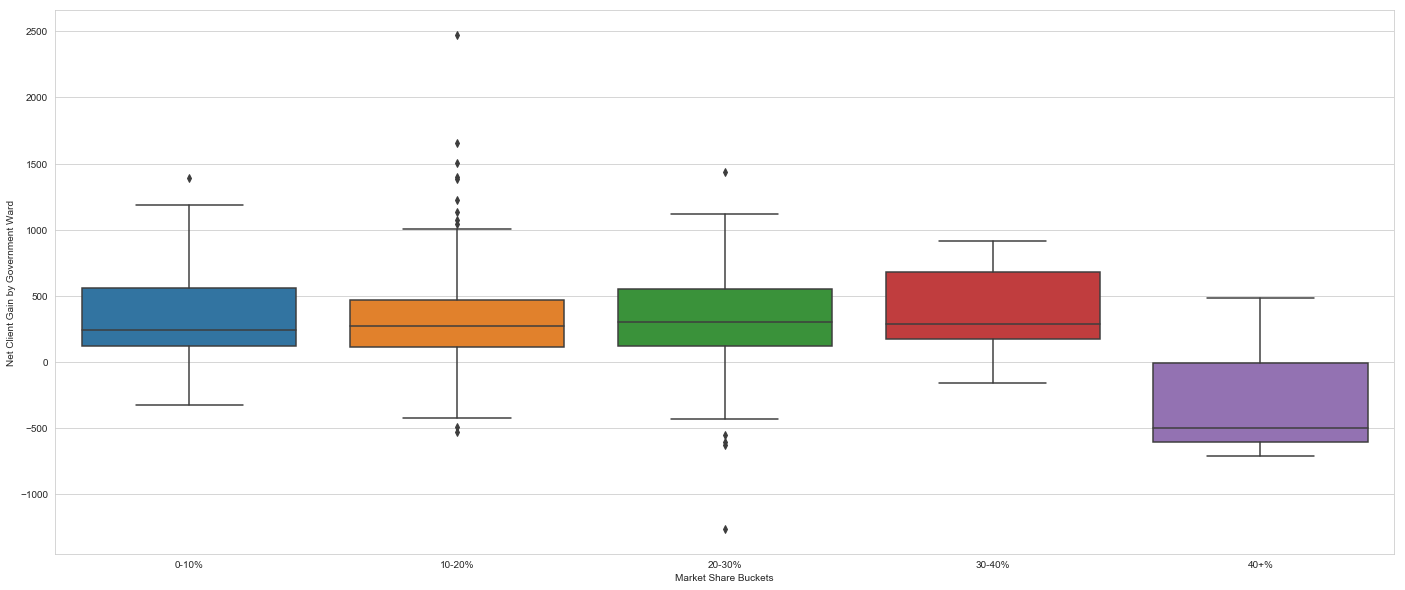

In [5]:
# Plotting x plots to show negative 
sns.set_style("whitegrid") 
Box2 = sns.boxplot(x = 'LR2017ClientDensity', y = 'LR2018NetClientGain', data = DensitybeforeDummies)
Box2.set_xlabel("Market Share Buckets");
Box2.set_ylabel("Net Client Gain by Government Ward");
Box2.set_xticklabels(['0-10%', '10-20%', '20-30%', '30-40%', '40+%']);

__Quality of Estimate of Market Share__: We used the rural household estimate from the 2009 census data as a proxy for the farming households in our wards of operation. The number of farming households is our real market. It is unclear how precise and accurate our estimate of market share because of this approximation. However, if we can source another population dataset, we may be able to cross-validate.